### LSTM Implementation

### Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import Series
from matplotlib import pyplot
import time
import math
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

### Data

In [2]:
data_raw=pd.read_csv("/home/rohan/Downloads/TechStocks.csv")

In [3]:
data=data_raw[["Date","AAPL","GOOG","MSFT"]]

In [4]:
data['Date'] = pd.to_datetime(data['Date'],infer_datetime_format=True) #convert from string to datetime
data = data.set_index(['Date'])
data.head(5)

,AAPL,GOOG,MSFT
Date,,,
2015-12-01,117.34,767.04,55.22
2015-12-02,116.28,762.38,55.21
2015-12-03,115.20,752.54,54.20
2015-12-04,119.03,766.81,55.91
2015-12-07,118.28,763.25,55.81


### Plot the data

Text(0.5, 1.0, 'Microsoft')

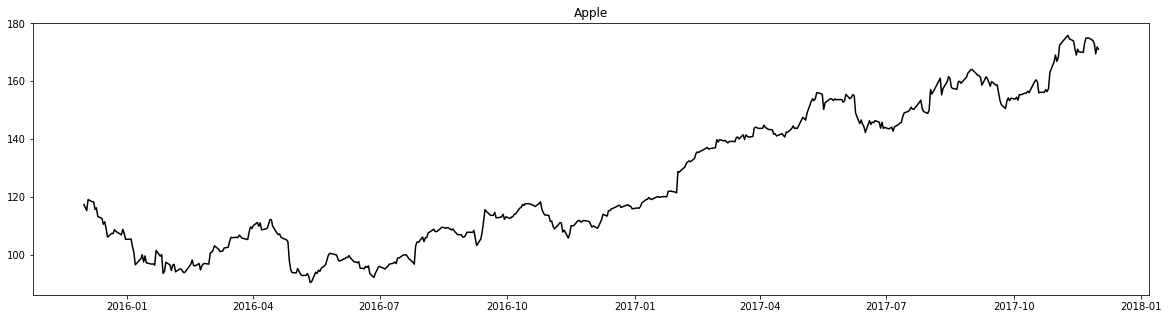

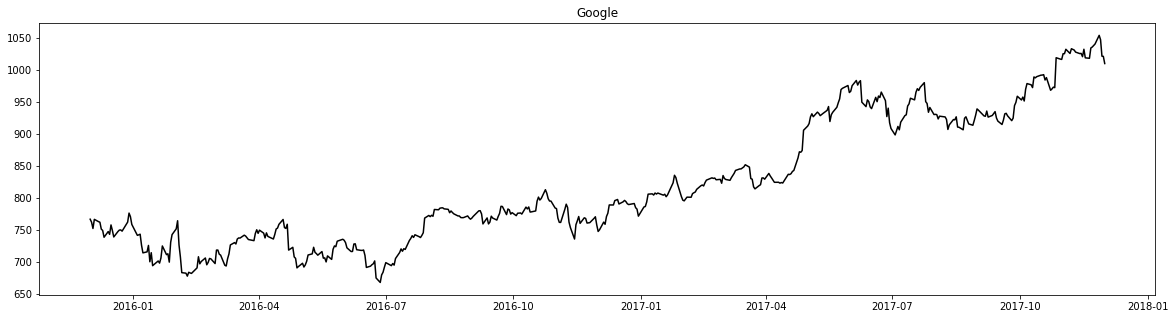

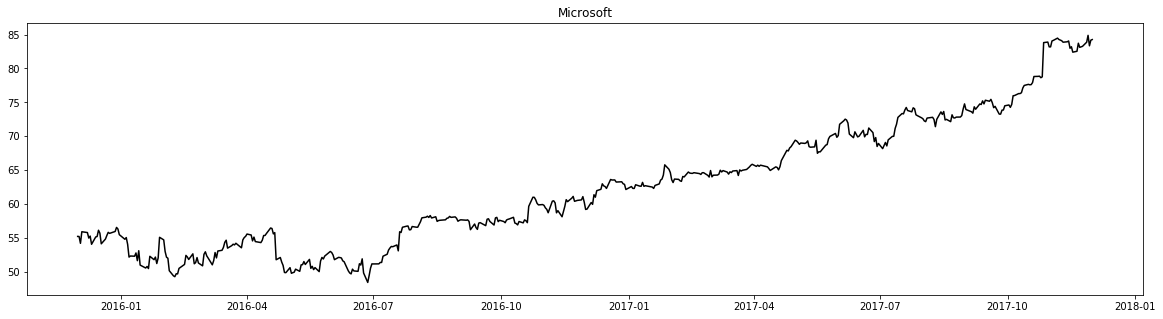

In [5]:
fig, ax = plt.subplots(figsize=(20,5))
plt.plot(data["AAPL"],"black")
ax.set_title('Apple')
fig, ax = plt.subplots(figsize=(20,5))
plt.plot(data["GOOG"],"black")
ax.set_title('Google')
fig, ax = plt.subplots(figsize=(20,5))
plt.plot(data["MSFT"],"black")
ax.set_title('Microsoft')


### Libraries for the model

In [7]:
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Activation, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle

Using TensorFlow backend.


### Prepare the Data

In [10]:
data_temp = data["AAPL"].values.astype("float32")

# We apply the MinMax scaler from sklearn
# to normalize data in the (0, 1) interval.
scaler = MinMaxScaler(feature_range = (0, 1))
data_temp=data_temp.reshape(-1,1)
dataset = scaler.fit_transform(data_temp)

# # Print a few values.
# dataset[0:5]

#### Train and test data

In [11]:
train=dataset[:480]
test=dataset[480:]

In [12]:
def create_dataset(dataset, window_size = 1):
    data_X, data_Y = [], []
    for i in range(len(dataset) - window_size - 1):
        a = dataset[i:(i + window_size), 0]
        data_X.append(a)
        data_Y.append(dataset[i + window_size, 0])
    return(np.array(data_X), np.array(data_Y))

In [13]:
window_size = 1
train_X, train_Y = create_dataset(train, window_size)
test_X, test_Y = create_dataset(test, window_size)
print("Original training data shape:")
print(train_X.shape)

# Reshape the input data into appropriate form for Keras.
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))
print("New training data shape:")
print(train_X.shape)

Original training data shape:
(478, 1)
New training data shape:
(478, 1, 1)


### Fit model

In [14]:
def fit_model(train_X, train_Y, window_size = 1):
    model = Sequential()
    
    model.add(LSTM(3, 
                   input_shape = (1, window_size)))
    model.add(Dense(1))
    model.compile(loss = "mean_squared_error", 
                  optimizer = "adam")
    model.fit(train_X, 
              train_Y, 
              epochs = 5, 
              batch_size = 1, 
              verbose = 2)
    
    return(model)

In [15]:
model1 = fit_model(train_X, train_Y, window_size)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/5
 - 4s - loss: 0.1097
Epoch 2/5
 - 1s - loss: 0.0409
Epoch 3/5
 - 1s - loss: 0.0179
Epoch 4/5
 - 1s - loss: 0.0034
Epoch 5/5
 - 1s - loss: 4.6694e-04


### Predict

In [16]:

def predict_and_score(model, X, Y):
    # Make predictions on the original scale of the data.
    pred = scaler.inverse_transform(model.predict(X))
    # Prepare Y data to also be on the original scale for interpretability.
    orig_data = scaler.inverse_transform([Y])
    # Calculate RMSE.
    score = math.sqrt(mean_squared_error(orig_data[0], pred[:, 0]))
    return(score, pred)

rmse_train, train_predict = predict_and_score(model1, train_X, train_Y)
rmse_test, test_predict = predict_and_score(model1, test_X, test_Y)

print("Training data score: %.2f RMSE" % rmse_train)
print("Test data score: %.2f RMSE" % rmse_test)

Training data score: 1.60 RMSE
Test data score: 5.20 RMSE


### Check the plot

<Figure size 1080x360 with 0 Axes>

Text(0.5, 0, 'Months')

Text(0, 0.5, '1000 International Airline Passengers')

Text(0.5, 1.0, 'Comparison true vs. predicted training / test')

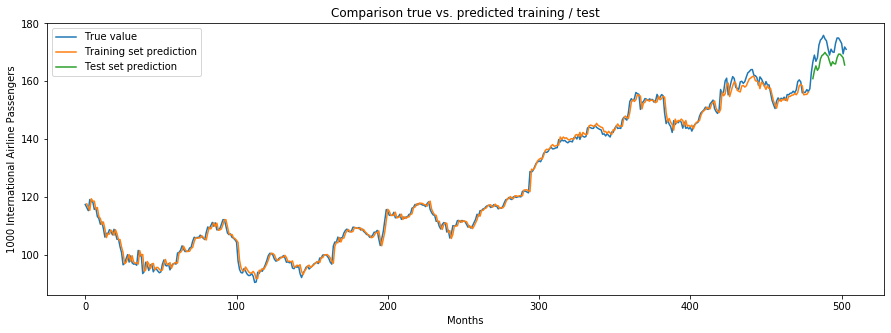

In [18]:
train_predict_plot = np.empty_like(dataset)
train_predict_plot[:, :] = np.nan
train_predict_plot[window_size:len(train_predict) + window_size, :] = train_predict

# Add test predictions.
test_predict_plot = np.empty_like(dataset)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + (window_size * 2) + 1:len(dataset) - 1, :] = test_predict

# Create the plot.
plt.figure(figsize = (15, 5))
plt.plot(scaler.inverse_transform(dataset), label = "True value")
plt.plot(train_predict_plot, label = "Training set prediction")
plt.plot(test_predict_plot, label = "Test set prediction")
plt.xlabel("Months")
plt.ylabel("1000 International Airline Passengers")
plt.title("Comparison true vs. predicted training / test")
plt.legend()
plt.show()

### Plot of Predicted vlaues and Actual Values

Text(0.5, 1.0, 'Predicted')

Text(0.5, 1.0, 'Actual Data')

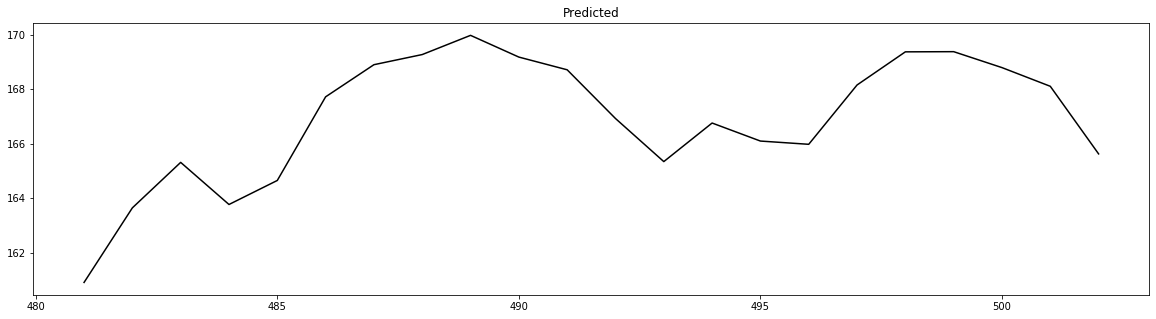

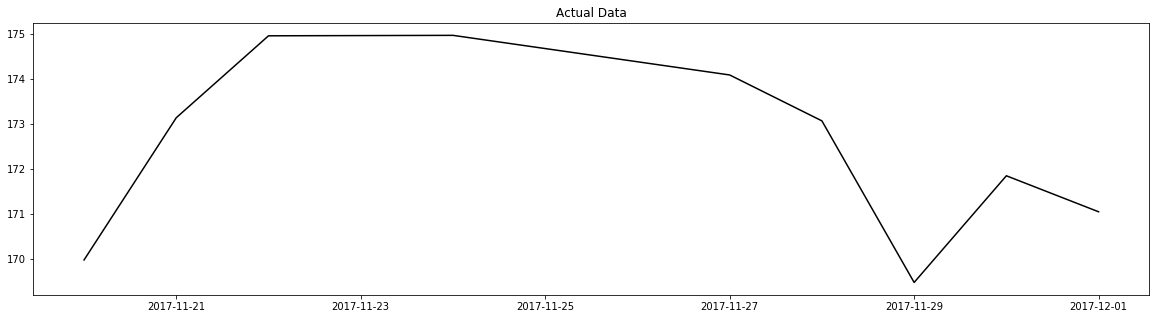

In [19]:
fig, ax = plt.subplots(figsize=(20,5))
plt.plot(test_predict_plot,"black")
ax.set_title('Predicted')
fig, ax = plt.subplots(figsize=(20,5))
plt.plot(data["AAPL"][495:],"black")
ax.set_title('Actual Data')

### Check the predicted and actual values

In [35]:
test_predict

array([[172.9222 ],
       [176.71857],
       [178.91344],
       [178.92549],
       [177.86353],
       [176.63425],
       [172.32338]], dtype=float32)

In [38]:
data["AAPL"][495:]

Date
2017-11-20    169.98
2017-11-21    173.14
2017-11-22    174.96
2017-11-24    174.97
2017-11-27    174.09
2017-11-28    173.07
2017-11-29    169.48
2017-11-30    171.85
2017-12-01    171.05
Name: AAPL, dtype: float64

Worked better than other models. 